In [1]:
import os
import sys
import math
import logging
from pathlib import Path

import numpy as np
import scipy as sp
import sklearn
import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("darkgrid")
sns.set_palette(sns.cubehelix_palette(8))

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

In [2]:
from enadepy.loaders import read_interm
from enadepy.index import get_index_dict

In [3]:
df_priv = read_interm('../data/interim/microdados_enade_ata_2016a2018_priv.csv')
df_pub = read_interm('../data/interim/microdados_enade_ata_2016a2018_pub.csv')

## Plot gender distribution by institution type

In [4]:
pub_dist = df_pub.TP_SEXO.value_counts()/df_pub.TP_SEXO.count() * 100
pub_dist

F    72.834646
M    27.165354
Name: TP_SEXO, dtype: float64

In [5]:
priv_dist = df_priv.TP_SEXO.value_counts()/df_priv.TP_SEXO.count() * 100
priv_dist

F    53.264383
M    46.735617
Name: TP_SEXO, dtype: float64

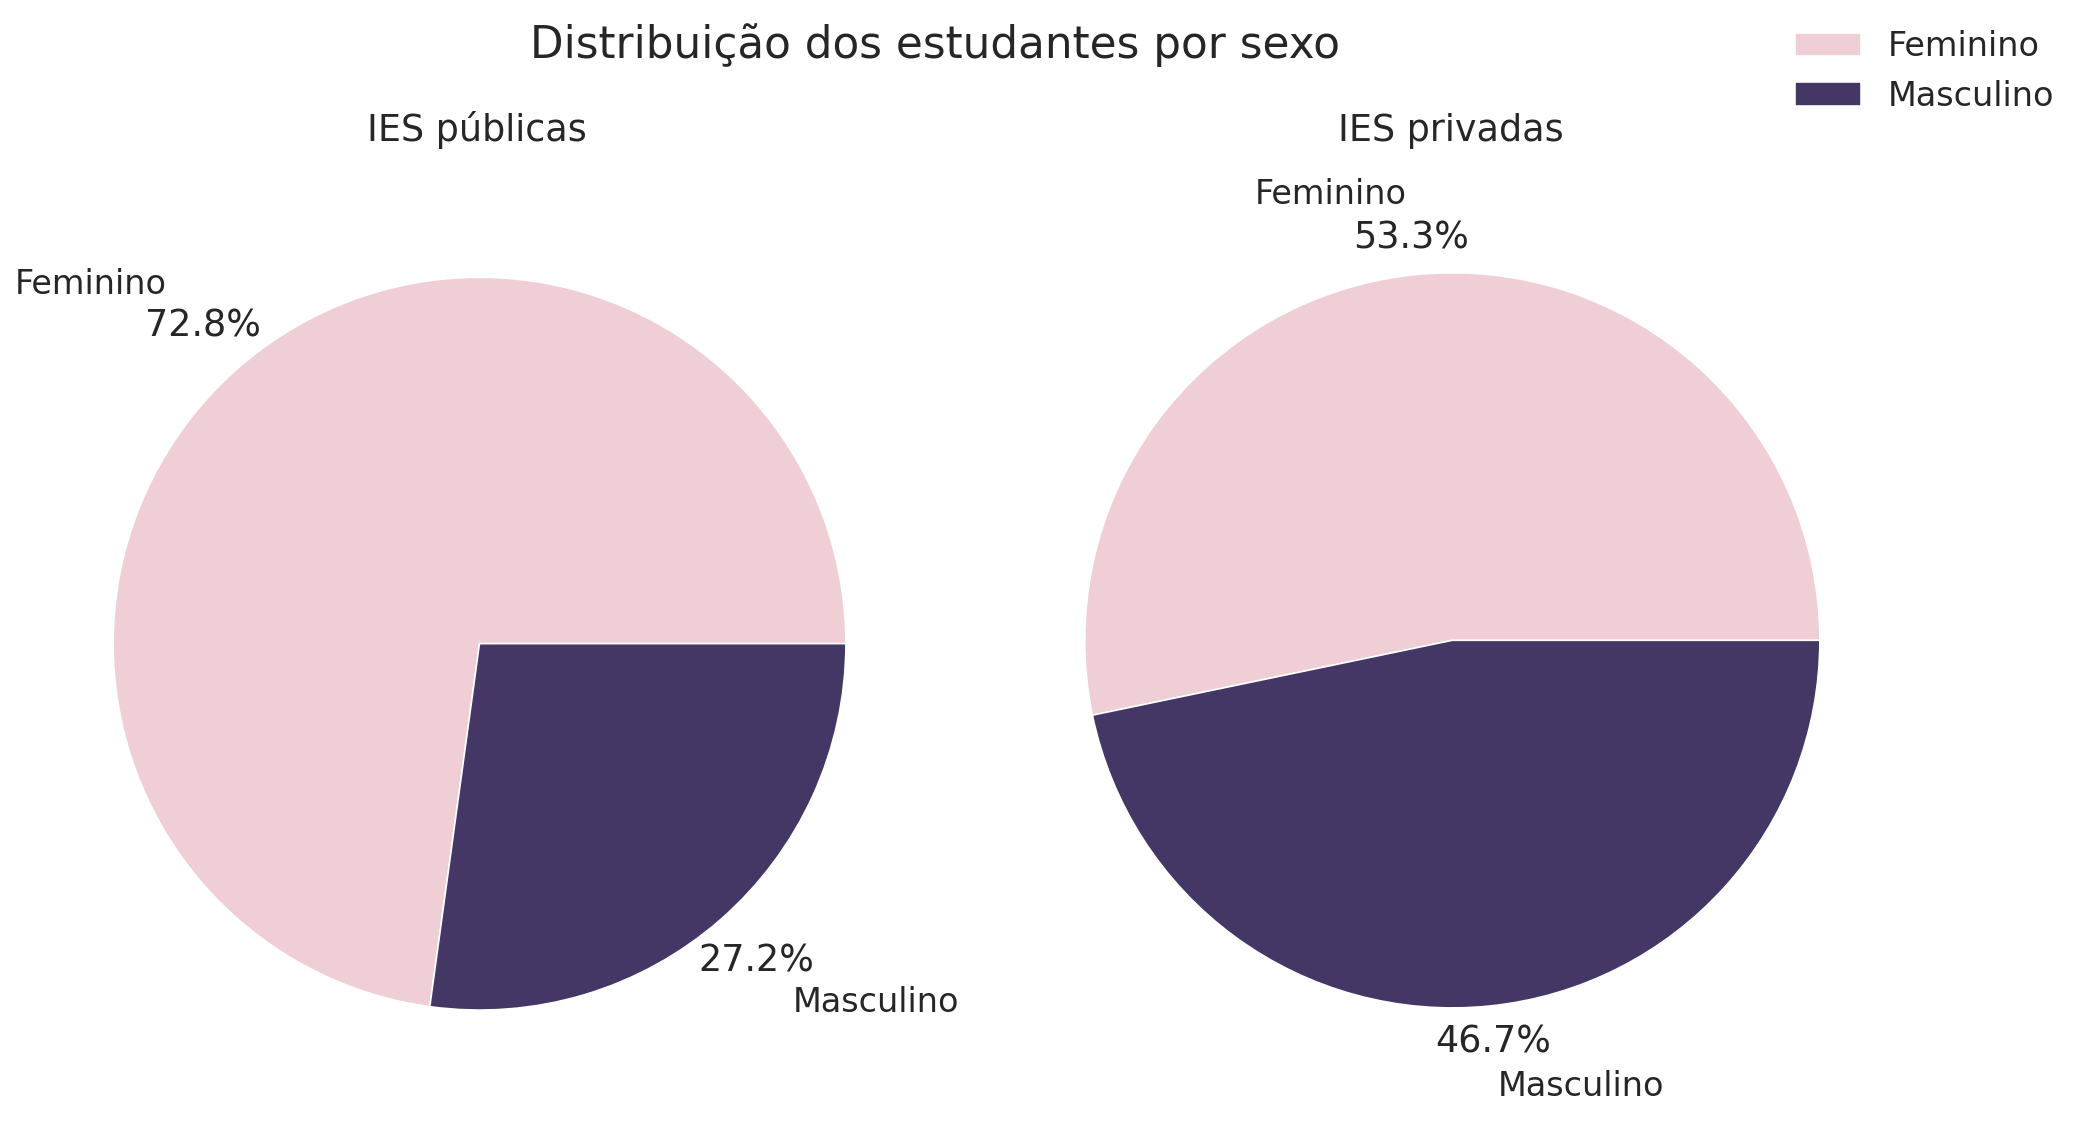

In [6]:
sns.set_context("paper", font_scale=1.9)
sns.set_style("darkgrid")
fig, (ax1, ax2) = plt.subplots(1, 2)
labels = ['Feminino', 'Masculino']

ax1.pie(pub_dist, labels=labels, colors=sns.cubehelix_palette(2, rot=.4, start=2.8, dark=.25), autopct='%1.1f%%', startangle=0,
       pctdistance=1.15, labeldistance=1.3)
ax1.axis('equal')

ax1.set_title("IES públicas")

ax2.pie(priv_dist, labels=labels, colors=sns.cubehelix_palette(2, rot=.4, start=2.8, dark=.25), autopct='%1.1f%%', startangle=0,
       pctdistance=1.1, labeldistance=1.22)
ax2.axis('equal')

ax2.set_title("IES privadas")

fig.suptitle("Distribuição dos estudantes por sexo")
handles, labels_f = ax1.get_legend_handles_labels()
fig.legend(handles, labels_f, loc='upper right', frameon=False)

# Save output
fig.savefig('../reports/figures/dist-sexo.png', dpi=300, bbox_inches='tight')

**Notes about pie chart**

It is possible to 'detach' a portion of a pie chart by especifying the argument 'explode'. For instance: explode=(0.1, 0)

## Plot histograms for the students' ages

In [7]:
pub_dist = df_pub.NU_IDADE
pub_dist

0      26
1      23
2      26
3      25
4      25
       ..
249    22
250    36
251    32
252    32
253    24
Name: NU_IDADE, Length: 254, dtype: Int64

In [8]:
priv_dist = df_priv.NU_IDADE
priv_dist

0       21
1       29
2       21
3       22
4       35
        ..
1542    24
1543    27
1544    23
1545    25
1546    34
Name: NU_IDADE, Length: 1547, dtype: Int64

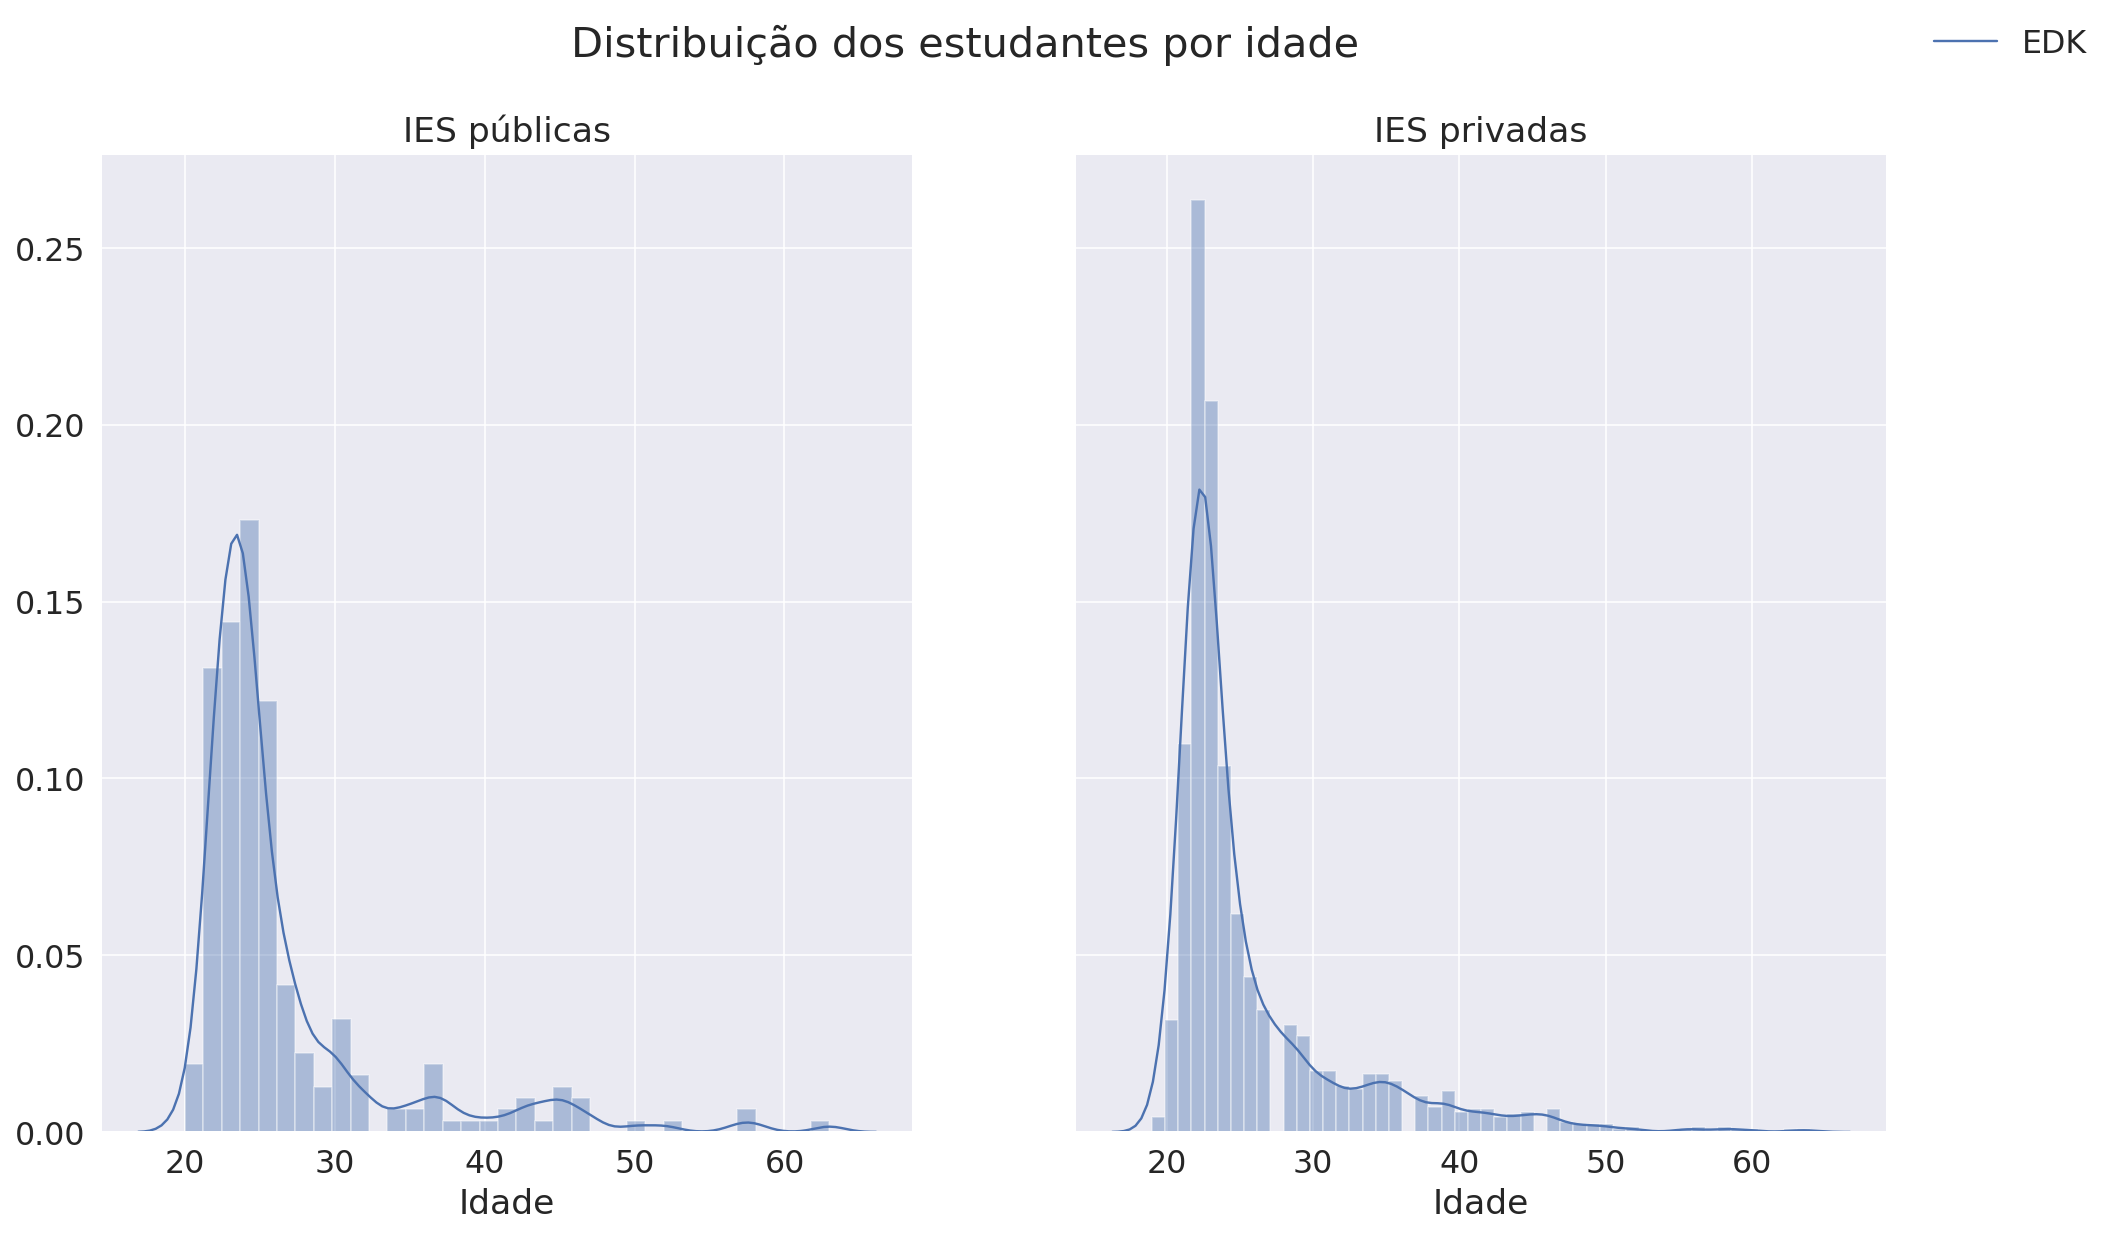

In [9]:
sns.set_context("paper", font_scale=1.8)
sns.set_style("darkgrid")
sns.set_palette("deep")
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
# labels = ['Feminino', 'Masculino']

sns.distplot(pub_dist, ax=ax1, axlabel='Idade', kde_kws={"label": "EDK", "legend": False})
handles, labels_f = ax1.get_legend_handles_labels()

sns.distplot(priv_dist, ax=ax2, axlabel='Idade')

ax1.set_title("IES públicas")
ax2.set_title("IES privadas")
fig.suptitle("Distribuição dos estudantes por idade")
fig.legend(handles, labels_f, loc='upper right', frameon=False)

# Save output
fig.savefig('../reports/figures/dist-idade.png', dpi=300, bbox_inches='tight')

## Plot the distribution of students by color

In [10]:
col_pub = df_pub.QE_I02
col_priv = df_priv.QE_I02

In [11]:
col_pub.value_counts()

A    193
D     40
C     10
B      9
F      2
Name: QE_I02, dtype: Int64

In [12]:
col_priv.value_counts()

A    1112
D     298
B      83
C      45
F       8
E       1
Name: QE_I02, dtype: Int64

In [13]:
df_col_pub = pd.DataFrame(data={"Cor ou raça": col_pub.value_counts().index, "Quantidade": col_pub.value_counts(), "Categoria IES": "Pública"})
df_col_pub['Quantidade (%)'] = df_col_pub['Quantidade'] / df_col_pub['Quantidade'].sum() * 100
df_col_pub

,Cor ou raça,Quantidade,Categoria IES,Quantidade (%)
A,A,193,Pública,75.984252
D,D,40,Pública,15.748031
C,C,10,Pública,3.937008
B,B,9,Pública,3.543307
F,F,2,Pública,0.787402


In [14]:
df_col_priv = pd.DataFrame(data={"Cor ou raça": col_priv.value_counts().index, 
                                 "Quantidade": col_priv.value_counts(),
                                 "Categoria IES": "Privada"})
df_col_priv['Quantidade (%)'] = df_col_priv['Quantidade'] / df_col_priv['Quantidade'].sum() * 100
df_col_priv

,Cor ou raça,Quantidade,Categoria IES,Quantidade (%)
A,A,1112,Privada,71.881060
D,D,298,Privada,19.263090
B,B,83,Privada,5.365223
C,C,45,Privada,2.908856
F,F,8,Privada,0.517130
E,E,1,Privada,0.064641


In [15]:
df_col = pd.concat([df_col_pub, df_col_priv]).reset_index(drop=True)
# df_col['Cor ou raça'] = pd.Categorical(df_col['Cor ou raça'], categories=get_index_dict('QE_I02').keys())
df_col['Cor ou raça'] = df_col['Cor ou raça'].map(get_index_dict('QE_I02'))

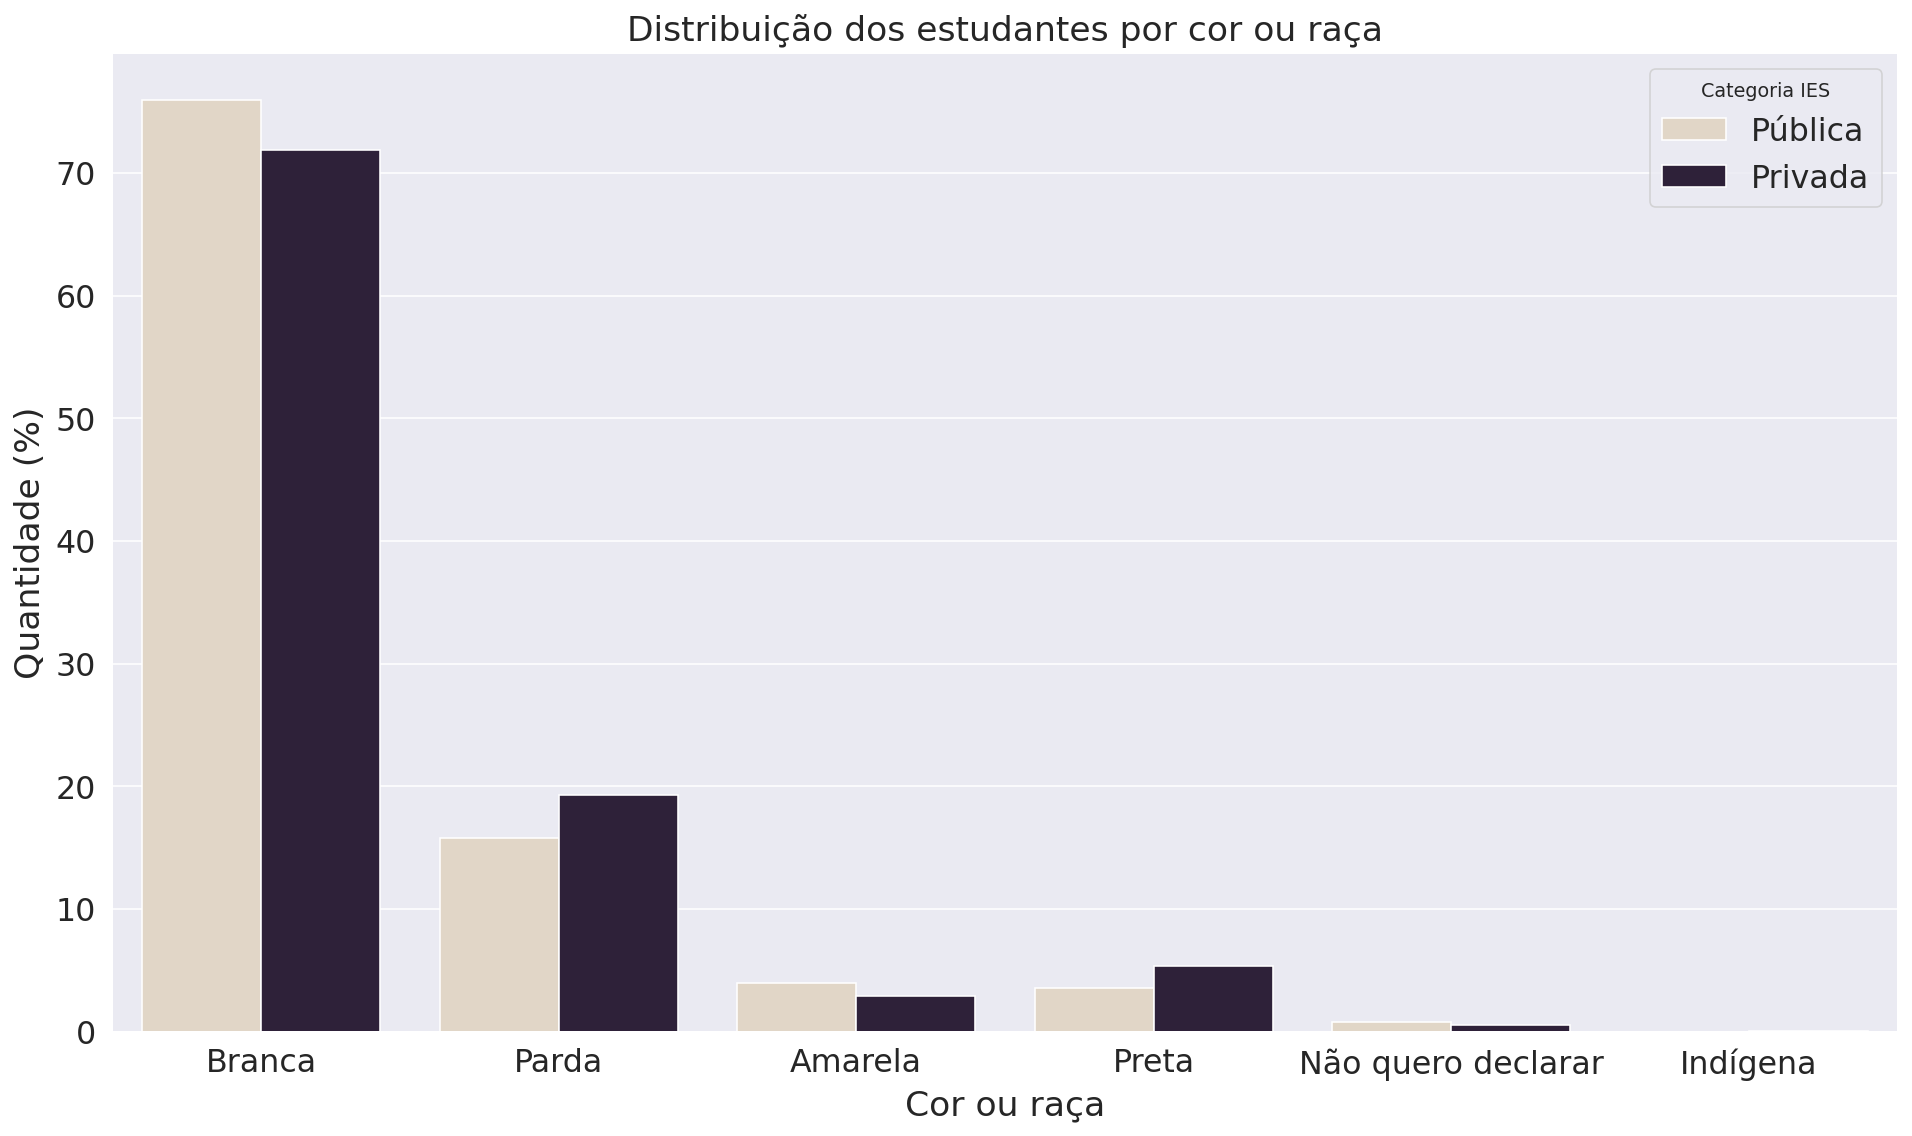

In [16]:
sns.set_context("paper", font_scale=1.8)
sns.set_style("darkgrid")


ax = sns.barplot(x='Cor ou raça', y='Quantidade (%)', hue='Categoria IES',
                 palette=sns.cubehelix_palette(2, rot=.5),
                 data=df_col)
ax.legend(loc="upper right", frameon=True, title="Categoria IES")
ax.set_title("Distribuição dos estudantes por cor ou raça")

# Save output
ax.figure.savefig('../reports/figures/dist-cor.png', dpi=300, bbox_inches='tight')

## References

https://towardsdatascience.com/python-plotting-basics-simple-charts-with-matplotlib-seaborn-and-plotly-e36346952a3a?gi=faac3e9f3531